In [1]:
import load_data as ld
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import sklearn.feature_extraction.text
import sklearn.multiclass
import sklearn.linear_model
% matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

In [2]:
df = ld.load_data()

C:\Users\kevin.rose\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2881: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
crime_df = df.ix[df['relevant'], :]
print(crime_df.shape)
crime_df = crime_df.ix[crime_df.loc[:, 'OEMC':'TASR'].any(1), :]
print(crime_df.shape)

idx = np.random.permutation(crime_df.shape[0])
trn = crime_df.iloc[idx[:int(crime_df.shape[0] * 0.7)], :]
tst = crime_df.iloc[idx[int(crime_df.shape[0] * 0.7):], :]
print(trn.shape)
print(tst.shape)

(112091, 45)
(34253, 45)
(23977, 45)
(10276, 45)


In [4]:
# vectorize data
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer=LemmaTokenizer(),
                                                             binary=True)
X = vectorizer.fit_transform(trn['bodytext'].values)

Y = trn.loc[:, 'OEMC':'TASR'].values

In [5]:
X.shape

(23977, 169333)

In [6]:
clf = sklearn.multiclass.OneVsRestClassifier(
    sklearn.linear_model.LogisticRegression()
)
clf.fit(X, Y)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [7]:
X_tst = vectorizer.transform(tst['bodytext'].values)
Y_tst = tst.loc[:, 'OEMC':'TASR'].values

Y_hat = clf.predict_proba(X_tst)

In [8]:
perf = pd.DataFrame()

for i in range(Y_hat.shape[1]):
    tag = tst.columns[7+i]
    perf.loc['TP', tag] = sum((Y_hat[:,i] > .5) & (Y_tst[:,i] == 1))
    perf.loc['FP', tag] = sum((Y_hat[:,i] > .5) & (Y_tst[:,i] == 0))
    perf.loc['TN', tag] = sum((Y_hat[:,i] < .5) & (Y_tst[:,i] == 0))
    perf.loc['FN', tag] = sum((Y_hat[:,i] < .5) & (Y_tst[:,i] == 1))
    perf.loc['TPR', tag] = perf.loc['TP', tag] / (perf.loc['TP', tag] + perf.loc['FN', tag])
    perf.loc['FPR', tag] = perf.loc['FP', tag] / (perf.loc['FP', tag] + perf.loc['TN', tag])
    perf.loc['PPV', tag] = perf.loc['TP', tag] / (perf.loc['TP', tag] + perf.loc['FP', tag])

perf = perf.T
perf

,TP,FP,TN,FN,TPR,FPR,PPV
OEMC,7.0,0.0,10239.0,30.0,0.189189,0.000000,1.000000
CPD,4506.0,1025.0,3853.0,892.0,0.834754,0.210127,0.814681
SAO,609.0,244.0,9067.0,356.0,0.631088,0.026206,0.713951
CCCC,324.0,220.0,9323.0,409.0,0.442019,0.023054,0.595588
CCJ,143.0,51.0,9973.0,109.0,0.567460,0.005088,0.737113
CCSP,253.0,68.0,9809.0,146.0,0.634085,0.006885,0.788162
CPUB,18.0,6.0,10195.0,57.0,0.240000,0.000588,0.750000
IDOC,27.0,6.0,10181.0,62.0,0.303371,0.000589,0.818182
DOMV,323.0,113.0,9643.0,197.0,0.621154,0.011583,0.740826
SEXA,628.0,61.0,9462.0,125.0,0.833997,0.006406,0.911466


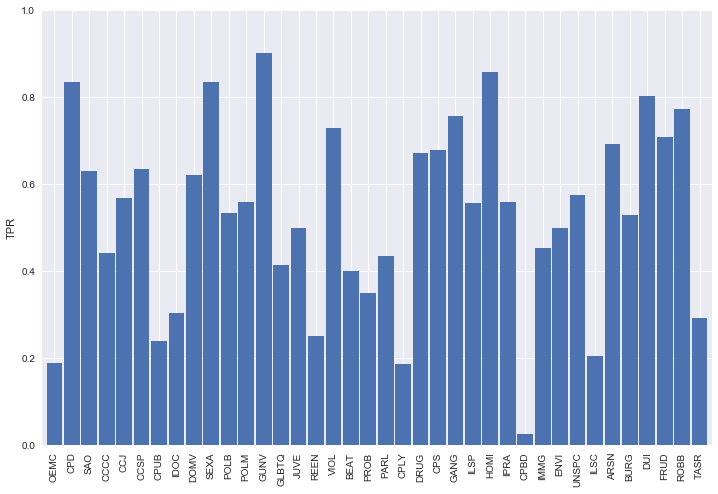

In [9]:
perf['TPR'].plot(kind='bar', ylim=[0,1], width=0.9)
plt.ylabel('TPR');

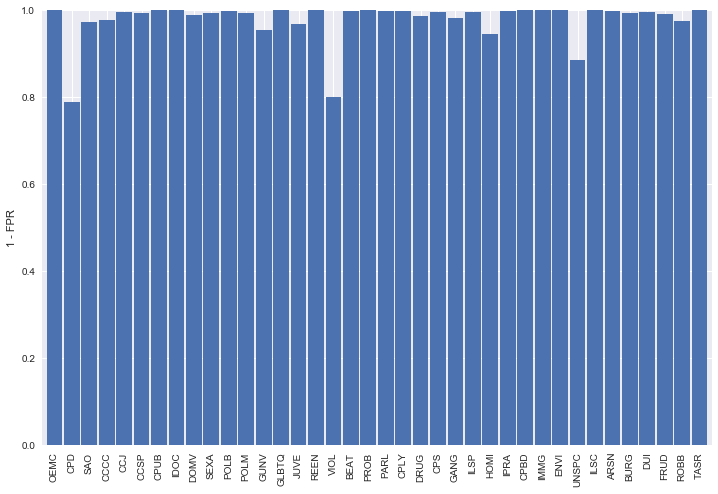

In [10]:
(1 - perf['FPR']).plot(kind='bar', ylim=[0,1], width=0.9)
plt.ylabel('1 - FPR');

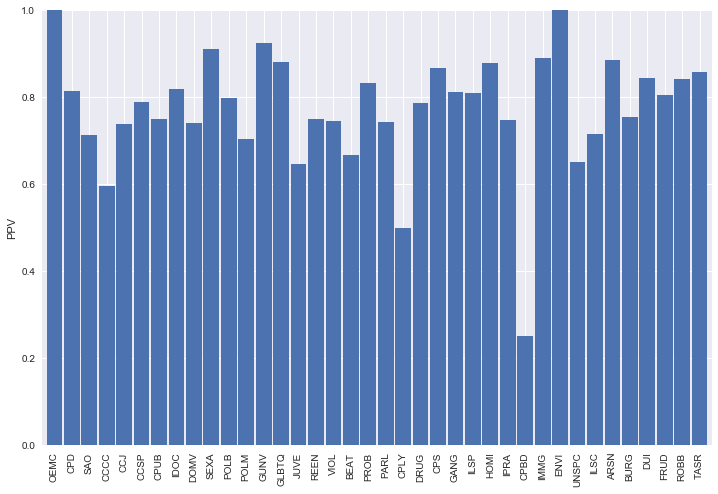

In [11]:
perf['PPV'].plot(kind='bar', ylim=[0,1], width=0.9)
plt.ylabel('PPV');

In [12]:
import benchmark_tagging as bt

In [13]:
print(bt.benchmark(
    lambda: sklearn.multiclass.OneVsRestClassifier(
        sklearn.linear_model.LogisticRegression()
    ),
    vectorizer.transform(crime_df['bodytext'].values),
    crime_df.loc[:, 'OEMC':'TASR'].values
))

[0.96414611961945962, 0.96402822424506907, 0.96383153961044155, 0.96409583458822223]


In [14]:
from importlib import reload
reload(bt)

<module 'benchmark_tagging' from 'C:\\Users\\kevin.rose\\Documents\\GitHub\\cjp-article-tagging\\src\\benchmark_tagging.py'>

In [16]:
np.mean([0.96414611961945962, 0.96402822424506907, 0.96383153961044155, 0.96409583458822223])

0.96402542951579817